In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/bowang-lab/MedSAM.git

  Cloning https://github.com/bowang-lab/MedSAM.git to /tmp/pip-req-build-oc7sf01h
  Running command git clone --filter=blob:none --quiet https://github.com/bowang-lab/MedSAM.git /tmp/pip-req-build-oc7sf01h
  Resolved https://github.com/bowang-lab/MedSAM.git to commit 861d42440061c704762a9bb9a574e7c31d8d751a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.5 MB/s eta 0:00:00
     

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
import monai
from segment_anything import sam_model_registry
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
train_data, val_data, test_data = np.load('/content/drive/MyDrive/train_data.npz'), np.load('/content/drive/MyDrive/val_data.npz'), np.load('/content/drive/MyDrive/test_data.npz')
X_train, masks_train, y_train = train_data['images'], train_data['masks'], train_data['labels']
X_val, masks_val, y_val = val_data['images'], val_data['masks'], val_data['labels']
X_test, masks_test, y_test = test_data['images'], test_data['masks'], test_data['labels']


In [22]:
# gt = masks_train[0]
# label_ids = np.unique(gt)[1:]
# gt2D = np.uint8(
#       gt == random.choice(label_ids.tolist()))
# gt2D_resized = transform.resize(gt2D, (256, 256), order=1, preserve_range=True, anti_aliasing=True)

In [23]:
# invalid_masks_indices = [i for i, mask in enumerate(masks_train_filtered) if np.max(mask) != 1 or np.min(mask) != 0]

In [4]:
# set seeds
torch.manual_seed(2023)
torch.cuda.empty_cache()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )

In [147]:
class SamData2(Dataset):
    def __init__(self, images, masks,labels, bbox_shift=20):
        self.images = images
        self.masks = masks
        self.data_len = len(images)
        self.labels=labels
        self.bbox_shift = bbox_shift

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        img=np.repeat(self.images[index],3,axis=-1)
        img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
        img_1024 = np.transpose(img_1024, (2, 0, 1))

        gt=self.masks[index]
        gt2D=np.squeeze(gt, axis=-1)

        assert np.max(gt2D) == 1 and np.min(gt2D) == 0.0, "ground truth should be 0, 1"
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])

        img_name=[index]
        return (
            torch.tensor(img_1024).float(),
            torch.tensor(gt2D[None, :, :]).long(),
            torch.tensor(bboxes).float(),
        )


In [162]:
class SamData3(Dataset):
    def __init__(self, images, masks,labels, bbox_shift=20):
        self.images = images
        self.masks = masks
        self.data_len = len(images)
        self.labels=labels
        self.bbox_shift = bbox_shift

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        img=np.repeat(self.images[index],3,axis=-1)
        img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
        img_1024 = np.transpose(img_1024, (2, 0, 1))

        gt=self.masks[index]
        gt2D=np.squeeze(gt, axis=-1)
        gt2D=transform.resize(gt2D, (1024, 1024), mode='constant', anti_aliasing=True)

        assert np.max(gt2D) == 1 and np.min(gt2D) == 0.0, "ground truth should be 0, 1"
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])

        img_name=[index]
        label=self.labels[index]
        return (
            torch.tensor(img_1024).float(),
            torch.tensor(gt2D[None, :, :]).long(),
            torch.tensor(bboxes).float(),
            torch.tensor(label)
        )


In [149]:
train_dataset = SamData2(images=X_train_filtered, masks=masks_train_filtered,labels=y_train_filtered)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [163]:
train_dataset = SamData3(images=X_train_filtered, masks=masks_train_filtered,labels=y_train_filtered)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [151]:
import argparse

args = argparse.Namespace(
    task_name="MedSAM-ViT-B",
    model_type="vit_b",
    checkpoint="work_dir/SAM/sam_vit_b_01ec64.pth",
    load_pretrain=True,
    pretrain_model_path="",
    num_epochs=1000,
    batch_size=1,
    num_workers=1,
    weight_decay=0.01,
    lr=0.0001,
    use_wandb=False,
    use_amp=True,
    world_size=None,
    node_rank=0,
    bucket_cap_mb=25,
    grad_acc_steps=1,
    resume="",
    init_method="env"
)

if args.use_wandb:
    import wandb
    wandb.login()
    wandb.init(
        project=args.task_name,
        config={
            "lr": args.lr,
            "batch_size": args.batch_size,
            "data_path": args.tr_npy_path,
            "model_type": args.model_type,
        },
    )


In [152]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")
# %% train
num_epochs = 1
iter_num = 0
losses = []
best_loss = 1e10

In [5]:
class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(box, dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)

            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )
        ori_res_masks = F.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

In [ ]:
sam_model = sam_model_registry[args.model_type](checkpoint=args.checkpoint)
medsam_model = MedSAM(
    image_encoder=sam_model.image_encoder,
    mask_decoder=sam_model.mask_decoder,
    prompt_encoder=sam_model.prompt_encoder,
).to(device)
medsam_model.train()

In [167]:
img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    medsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=0.001, weight_decay=0.01
)
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
# cross entropy loss
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")
# %% train
num_epochs = 1
iter_num = 0
losses = []
best_loss = 1e10
train_dataset = SamData3(images=X_train_filtered, masks=masks_train_filtered,labels=y_train_filtered)

In [156]:
run_id = datetime.now().strftime("%Y%m%d-%H%M")

In [157]:
torch.cuda.empty_cache()

In [168]:
medsam_model.train()
from torch.cuda.amp import autocast, GradScaler
start_epoch = 0
num_epochs = 5

scaler = GradScaler()

for epoch in range(start_epoch, num_epochs):
    epoch_loss = 0
    for step, (image, gt2D, boxes, _) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        boxes_np = boxes.detach().cpu().numpy()
        image, gt2D = image.to(device), gt2D.to(device)
        torch.cuda.empty_cache()

        medsam_pred = medsam_model(image, boxes_np)
        loss = seg_loss(medsam_pred, gt2D) + ce_loss(medsam_pred, gt2D.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        iter_num += 1

    epoch_loss /= step
    losses.append(epoch_loss)
    print(
        f'Time: {datetime.now().strftime("%Y%m%d-%H%M")}, Epoch: {epoch}, Loss: {epoch_loss}'
    )
    ## save the latest model
    checkpoint = {
        "model": medsam_model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
    }
    checkpoint_path = f'/content/drive/MyDrive/medsam/fine_tuned_model_epoch_{epoch}.pth'
    torch.save(checkpoint, checkpoint_path)
## save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            "model": medsam_model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        best_checkpoint_path = '/content/drive/MyDrive/medsam/fine_tuned_model_best.pth'
        torch.save(checkpoint, best_checkpoint_path)


100%|██████████| 1554/1554 [57:27<00:00,  2.22s/it]


Time: 20231208-0242, Epoch: 0, Loss: 0.40100499004106405


100%|██████████| 1554/1554 [56:37<00:00,  2.19s/it]


Time: 20231208-0339, Epoch: 1, Loss: 0.2692341022745149


100%|██████████| 1554/1554 [57:22<00:00,  2.22s/it]


Time: 20231208-0437, Epoch: 2, Loss: 0.22763167149930022


100%|██████████| 1554/1554 [57:07<00:00,  2.21s/it]


Time: 20231208-0534, Epoch: 3, Loss: 0.5377124948457066


100%|██████████| 1554/1554 [57:24<00:00,  2.22s/it]


Time: 20231208-0631, Epoch: 4, Loss: 0.2390289683199589


In [174]:
losses

[0.40100499004106405,
 0.2692341022745149,
 0.22763167149930022,
 0.5377124948457066,
 0.2390289683199589]

In [177]:
plt.plot(x,losses,marker='o')
plt.title("MedSAM Training \n Dice + Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(x)
plt.savefig(join("train_loss.png"))
plt.close()

In [184]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
#%% load model and image
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
map_location=torch.device('cpu')
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
model_id = "1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_&confirm=t"
!gdown $model_id
#%% load model and image
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
map_location=torch.device('cpu')
pretrained_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

Downloading...
From: https://drive.google.com/uc?id=1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_
To: /content/medsam_vit_b.pth
100% 375M/375M [00:04<00:00, 90.5MB/s]


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [25]:
valid_indices = [i for i, mask in enumerate(masks_val) if np.max(mask) != 0]
X_val_filtered=X_val[valid_indices]
masks_val_filtered=masks_val[valid_indices]
y_val_filtered=y_val[valid_indices]
l=len(valid_indices)

In [6]:
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [18]:
def get_bounding_box(mask):
    # Find the non-zero indices in the mask
    non_zero_indices = np.where(mask)

    if len(non_zero_indices[0]) == 0:
        # Return a placeholder value for an empty mask
        return np.zeros((1, 4))

    # Compute the bounding box coordinates
    min_y, min_x = np.min(non_zero_indices, axis=1)
    max_y, max_x = np.max(non_zero_indices, axis=1)

    # Return the bounding box coordinates as a 2D array
    return np.array([[min_x, min_y, max_x, max_y]])




In [ ]:
H, W = 500, 500
valid_bbox = np.zeros((l,1, 4))

for i, mask in enumerate(masks_val_filtered):
    mask = np.squeeze(mask, axis=-1)
    bbox = get_bounding_box(mask)
    valid_bbox[i] = bbox / np.array([W, H, W, H]) * 1024

In [ ]:
Val_image1024_tensors = []
# Val_image1024 = []

for i, img in enumerate(X_val_filtered):
  img=np.repeat(img,3,axis=-1)
  img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
  img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
  # Val_image1024.append(img_1024)
  Val_image1024_tensors.append(img_1024_tensor)

In [27]:
val_img=X_val_filtered[0]
val_img=np.repeat(val_img,3,axis=-1)
val_img_1024 = transform.resize(val_img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)


In [33]:
val_mask_true=masks_val_filtered[0].squeeze(-1)

In [32]:
val_mask_true

(500, 500)

In [36]:
import cv2
val_true_resized_mask = cv2.resize(val_mask_true, (1024, 1024))

In [29]:
val_bbox=[262.144, 395.264, 665.6  , 575.488]

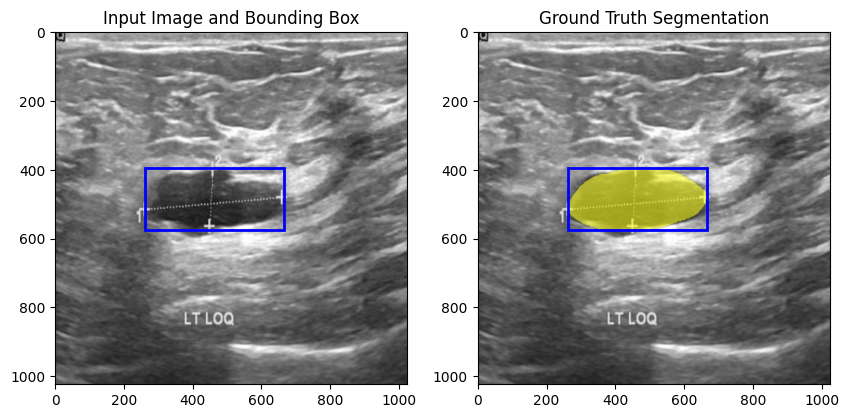

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(val_img_1024)
show_box(val_bbox, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(val_img_1024)
show_mask(val_true_resized_mask, ax[1])
show_box(val_bbox, ax[1])
ax[1].set_title("Ground Truth Segmentation")
plt.show()

In [102]:
valid_bbox[0]

array([[262.144, 395.264, 665.6  , 575.488]])

In [52]:
seg_result=[]
for i in range(0,l):
  x=Val_image1024_tensors[i]
  y=valid_bbox[i]
  with torch.no_grad():
    image_embedding = pretrained_model.image_encoder(x)
  medsam_seg = medsam_inference(pretrained_model, image_embedding, y, 1024, 1024)
  medsam_seg_tensor = torch.from_numpy(medsam_seg).unsqueeze(0).unsqueeze(0)
  seg_result.append(medsam_seg_tensor)
seg_result = torch.cat(seg_result, dim=0)

In [53]:
seg_result_resized = F.interpolate(seg_result, size=(500, 500), mode='nearest')

In [ ]:
tensor_masks = torch.tensor(masks_val_filtered)
tensor_masks = tensor_masks.squeeze(-1)
tensor_masks = tensor_masks.unsqueeze(1)

In [26]:
from monai.metrics import MeanIoU
pretrained_mean_iou_metric = MeanIoU(include_background=True, reduction="mean")

In [93]:
pretrained_iou=pretrained_mean_iou_metric(seg_result_resized, tensor_masks)

In [94]:
pretrained_mean_iou=pretrained_mean_iou_metric.aggregate()

In [95]:
pretrained_mean_iou

tensor([0.8761])

In [9]:
import torch

# %% convert medsam model checkpoint to sam checkpoint format for convenient inference
sam_ckpt_path = "medsam_vit_b.pth"
medsam_ckpt_path = '/content/drive/MyDrive/medsam/fine_tuned_model_best.pth'
save_path = "/content/drive/MyDrive/medsam/best_model_sam.pth"
multi_gpu_ckpt = False  # set as True if the model is trained with multi-gpu

sam_ckpt = torch.load(sam_ckpt_path)
medsam_ckpt = torch.load(medsam_ckpt_path)
sam_keys = sam_ckpt.keys()
for key in sam_keys:
    if not multi_gpu_ckpt:
        sam_ckpt[key] = medsam_ckpt["model"][key]
    else:
        sam_ckpt[key] = medsam_ckpt["model"]["module." + key]

torch.save(sam_ckpt, save_path)

KeyboardInterrupt: ignored

In [10]:
checkpoint_path = '/content/drive/MyDrive/medsam/best_model_sam.pth'
finetuned_model = sam_model_registry['vit_b'](checkpoint=checkpoint_path)
finetuned_model = finetuned_model.to(device)
finetuned_model.eval

<bound method Module.eval of Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [28]:
finetuned_seg_result=[]
for i in range(0,l):
  x=Val_image1024_tensors[i]
  y=valid_bbox[i]
  with torch.no_grad():
    image_embedding = finetuned_model.image_encoder(x)
  medsam_seg = medsam_inference(finetuned_model, image_embedding, y, 1024, 1024)
  medsam_seg_tensor = torch.from_numpy(medsam_seg).unsqueeze(0).unsqueeze(0)
  finetuned_seg_result.append(medsam_seg_tensor)
finetuned_seg_result = torch.cat(finetuned_seg_result, dim=0)

NameError: ignored

In [76]:
finetuned_seg_result_resized = F.interpolate(finetuned_seg_result, size=(500, 500), mode='nearest')

In [88]:
finetuned_mean_iou_metric = MeanIoU(include_background=True, reduction="mean")

In [89]:
finetuned_iou=finetuned_mean_iou_metric(finetuned_seg_result_resized, tensor_masks)

In [90]:
mean_finetuned_iou=finetuned_mean_iou_metric.aggregate()

In [91]:
mean_finetuned_iou

tensor([0.6578])

In [107]:
val_seg=finetuned_seg_result[0]

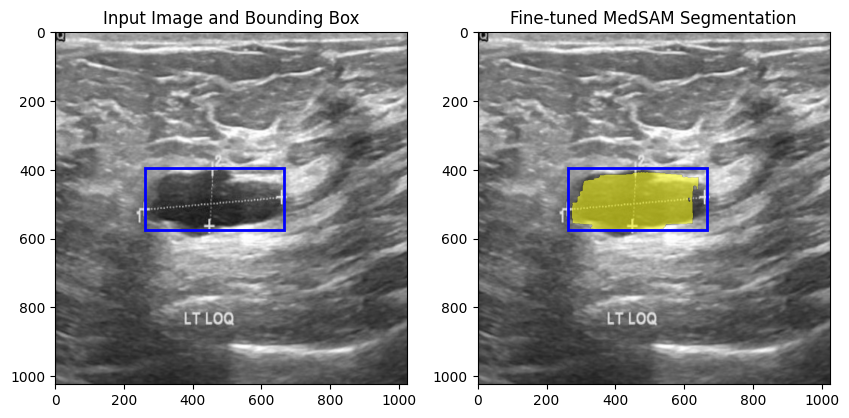

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(val_img_1024)
show_box(val_bbox, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(val_img_1024)
show_mask(val_seg, ax[1])
show_box(val_bbox, ax[1])
ax[1].set_title("Fine-tuned MedSAM Segmentation")
plt.show()

In [14]:
X_test, masks_test, y_test = test_data['images'], test_data['masks'], test_data['labels']


In [15]:
test_indices = [i for i, mask in enumerate(masks_test) if np.max(mask) != 0]
X_test_filtered=X_test[test_indices]
masks_test_filtered=masks_test[test_indices]
y_test_filtered=y_test[test_indices]
lt=len(test_indices)

In [20]:
H, W = 500, 500
test_bbox = np.zeros((lt,1, 4))

for i, mask in enumerate(masks_test_filtered):
    mask = np.squeeze(mask, axis=-1)
    bbox = get_bounding_box(mask)
    test_bbox[i] = bbox / np.array([W, H, W, H]) * 1024


In [22]:
test_tensor_masks = torch.tensor(masks_test_filtered)
test_tensor_masks = test_tensor_masks.squeeze(-1)
test_tensor_masks = test_tensor_masks.unsqueeze(1)

In [23]:
test_image1024_tensors = []
# Val_image1024 = []

for i, img in enumerate(X_test_filtered):
  img=np.repeat(img,3,axis=-1)
  img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
  img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
  # Val_image1024.append(img_1024)
  test_image1024_tensors.append(img_1024_tensor)

In [24]:
test_finetuned_seg_result=[]
for i in range(0,lt):
  x=test_image1024_tensors[i]
  y=test_bbox[i]
  with torch.no_grad():
    image_embedding = finetuned_model.image_encoder(x)
  medsam_seg = medsam_inference(finetuned_model, image_embedding, y, 1024, 1024)
  medsam_seg_tensor = torch.from_numpy(medsam_seg).unsqueeze(0).unsqueeze(0)
  test_finetuned_seg_result.append(medsam_seg_tensor)
test_finetuned_seg_result = torch.cat(test_finetuned_seg_result, dim=0)
test_finetuned_seg_result_resized = F.interpolate(test_finetuned_seg_result, size=(500, 500), mode='nearest')

In [30]:
test_finetuned_mean_iou_metric = MeanIoU(include_background=True, reduction="mean")
test_finetuned_iou=test_finetuned_mean_iou_metric(test_finetuned_seg_result_resized, test_tensor_masks)
test_mean_finetuned_iou=test_finetuned_mean_iou_metric.aggregate()

In [31]:
test_mean_finetuned_iou

tensor([0.6593])

In [67]:
from monai.metrics import ConfusionMatrixMetric
from monai.utils import MetricReduction
test_mean_conf_metric = ConfusionMatrixMetric(include_background=True, reduction=MetricReduction.MEAN,metric_name ="ppv")

In [73]:
from monai.metrics import get_confusion_matrix, compute_confusion_matrix_metric

In [72]:
test_conf=get_confusion_matrix(test_finetuned_seg_result_resized, test_tensor_masks)

In [75]:
test_precision=compute_confusion_matrix_metric(metric_name="precision",confusion_matrix=test_conf)

In [81]:
test_precision.shape

torch.Size([65, 1])

In [84]:
torch.mean(test_precision)

tensor(0.8497)